In [1]:
import json
import time
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations, combinations
from ipywidgets import IntProgress
from IPython.display import display as pbdisplay
from IPython.display import clear_output
from scipy.interpolate import lagrange
import shutil
import sys
import os.path
from sklearn.decomposition import PCA
from multiprocessing import Pool
from sklearn.neighbors import KNeighborsClassifier

from mpl_toolkits.mplot3d import Axes3D
import random

from pyomo.environ import *
from pyomo.gdp import *

from sklearn.cluster import KMeans

In [3]:
timeout = 10
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.random.randint(0, 100, size=(a,))
            rs.sort()
            ps = np.random.randint(0, 100, size=(a,))
            ds = np.zeros(shape=(a,))
            for i in range(len(ds)): 
                dlow = rs[i] + ps[i] + 1
                ds[i] = np.random.randint(dlow, dlow+100)
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self
    
    def scale(self, alpha, key='r'):
        if key == 'r': ind = 0
        elif key == 'p': ind = 1
        else: ind = 2
        self.array[:,ind] = self.array[:,ind]*alpha
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return bestPi, -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if i.nu < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        
def bruteforce(N, tau=0):
    best_L = N.L_max(tau)
    best_N = N.copy()
    for perm in permutations(N):
        s = TaskSet(perm)
        L = s.L_max(tau)
        if L < best_L:
            best_L = L
            best_N = s.copy()
    return best_L, best_N


In [47]:
s = TaskSet(10)

In [48]:
s.array[:,0] = s.array[:,0] * 0.001

In [49]:
pi, c = main(s, verbose=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


[0, 2, 5, 6, 4, 9, 8, 1, 3, 7] 	Lmax = 140.01


In [50]:
s[:,2][pi]

  r  |  p  |  d  
[ 94.  73. 106. 107. 126. 136. 138. 187. 187. 206.]

# Генерируем возможные требования

In [8]:
N_POINTS = 6

points = range(1, N_POINTS + 1)
jobs = []
for ri in points:
    for pi in range(ri, N_POINTS + 1):
        for di in range(ri + pi, N_POINTS + 1):
            jobs.append((ri, pi, di))
            #if ri % 2 == 0:
            #    if di < N_POINTS:
            #        jobs.append((2*ri+1, 2*pi+1, 2*di+1))
            #jobs.append((2*ri, 2*pi, 2*di))

In [9]:
# remove jobs with (1, 1, d)
jobs = jobs[5:]

In [10]:
jobs

[(1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (1, 5, 6),
 (2, 2, 4),
 (2, 2, 5),
 (2, 2, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 6),
 (3, 3, 6)]

In [11]:
rs = list(map(lambda x: x[0], jobs))
ps = list(map(lambda x: x[1], jobs))
ds = list(map(lambda x: x[2], jobs))

# Пространство (r, p, d)

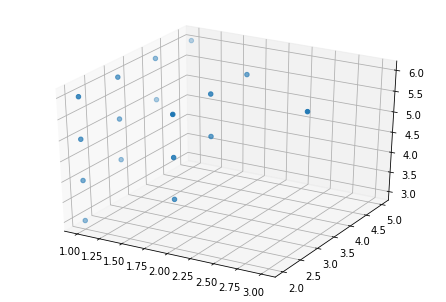

In [12]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rs, ps, ds)

# Загружаем датасет

In [3]:
df = pd.read_excel("big8.xlsx")

In [4]:
df = df.drop(['index'], axis=1)

# Ужимаем размерность

In [24]:
pca = PCA(n_components=2)
coords = []
for i in df.Instance.values:
    coords.append(json.loads(i.replace(" ", ', ')))
coords_pca = pca.fit_transform(coords)

In [25]:
pca = PCA(n_components=3)
coords = []
for i in df.Instance.values:
    coords.append(json.loads(i.replace(" ", ', ')))
coords_pca3 = pca.fit_transform(coords)

In [41]:
pca = PCA(n_components=3)
coords = []
for i in df.Schedule.values:
    coords.append(json.loads(i))
coords_pca3_scheds = pca.fit_transform(coords)

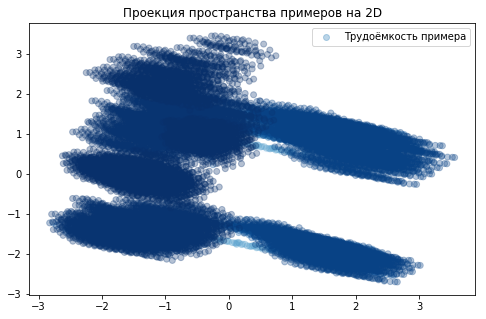

In [55]:
fig = plt.figure(figsize=(8,5))
plt.scatter(coords_pca[:,0], coords_pca[:,1], c=df.Complexity.values, alpha=0.3, cmap='Blues', label='Трудоёмкость примера')
plt.title("Проекция пространства примеров на 2D")
plt.legend()

Text(0.5, 0.92, 'Проекция пространства примеров на 3D')

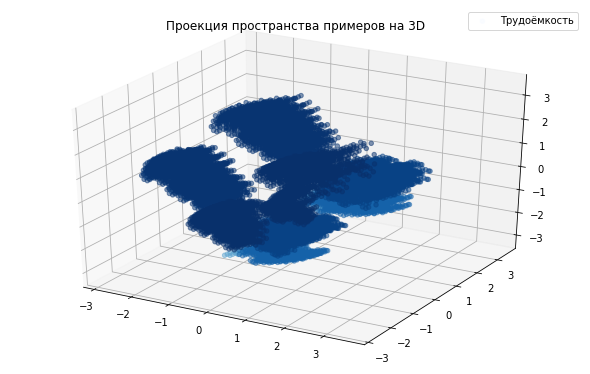

In [27]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca3[:,0], coords_pca3[:,1], coords_pca3[:,2], c=df['Complexity'].values, depthshade=False, alpha=0.5, cmap='Blues', label='Трудоёмкость')
ax.legend()
ax.set_title("Проекция пространства примеров на 3D")

Text(0.5, 0.92, 'Проекция пространства расписаний на 3D')

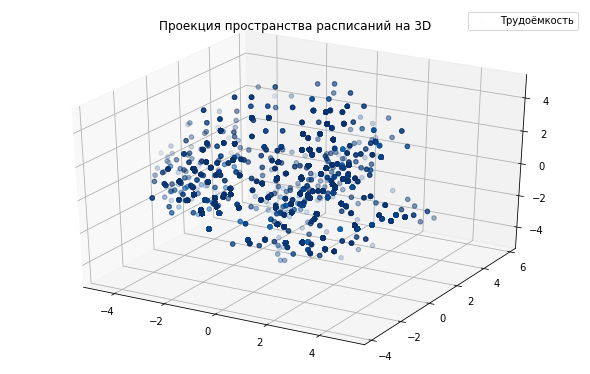

In [43]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca3_scheds[:,0], coords_pca3_scheds[:,1], coords_pca3_scheds[:,2], c=df['Complexity'].values, depthshade=False, alpha=0.1, cmap='Blues', label='Трудоёмкость')
ax.legend()
ax.set_title("Проекция пространства расписаний на 3D")

Text(0, 0.5, 'Время решения примера')

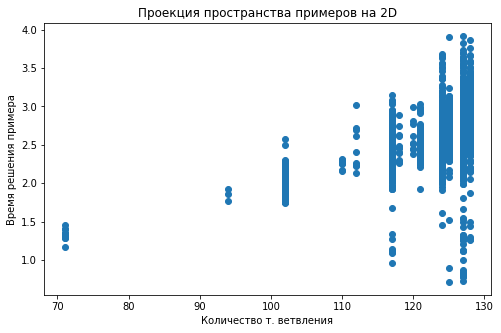

In [51]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df.Complexity.values, df['Orig time'].values, alpha=1, cmap='Blues', label='Трудоёмкость примера')
plt.title("Проекция пространства примеров на 2D")
plt.xlabel("Количество т. ветвления")
plt.ylabel("Время решения примера")

# Кластеризация (с учётом трудоёмкости)

In [28]:
cluster_coords = []
for i in zip(coords, df['Complexity'].values):
    t = [j for j in i[0]]
    t.append(i[1])
    cluster_coords.append(t)

In [29]:
kmeans2 = KMeans(n_clusters=2).fit_predict(cluster_coords)
kmeans4 = KMeans(n_clusters=4).fit_predict(cluster_coords)
kmeans8 = KMeans(n_clusters=8).fit_predict(cluster_coords)

In [30]:
pca = PCA(n_components=3)
coords_pca = pca.fit_transform(cluster_coords)

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

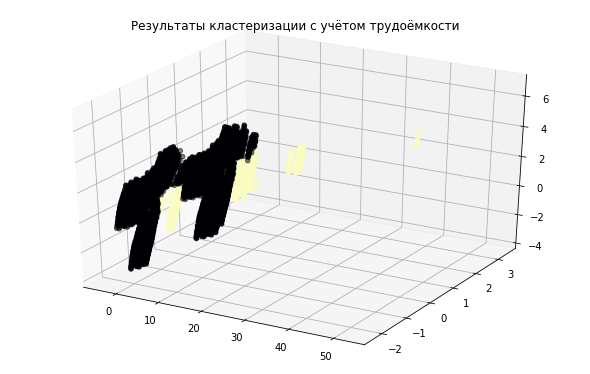

In [31]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans2, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

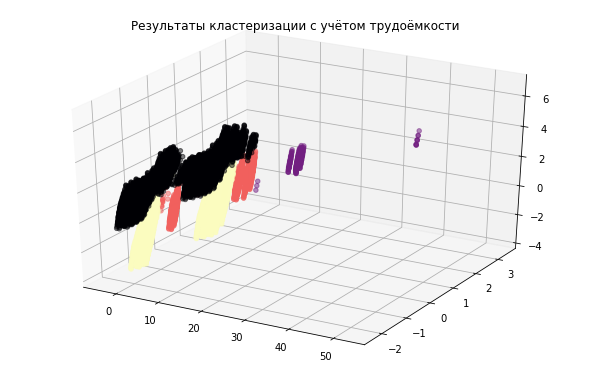

In [32]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans4, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

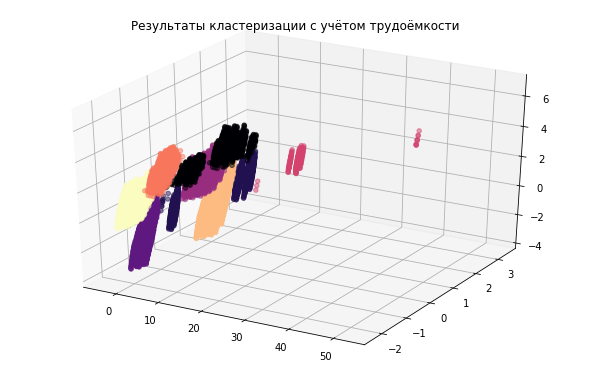

In [33]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans8, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

# Кластеризация без учёта трудоёмкости

In [34]:
kmeans2 = KMeans(n_clusters=2).fit_predict(coords)
kmeans4 = KMeans(n_clusters=4).fit_predict(coords)
kmeans8 = KMeans(n_clusters=8).fit_predict(coords)

In [35]:
pca = PCA(n_components=3)
coords_pca = pca.fit_transform(coords)

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

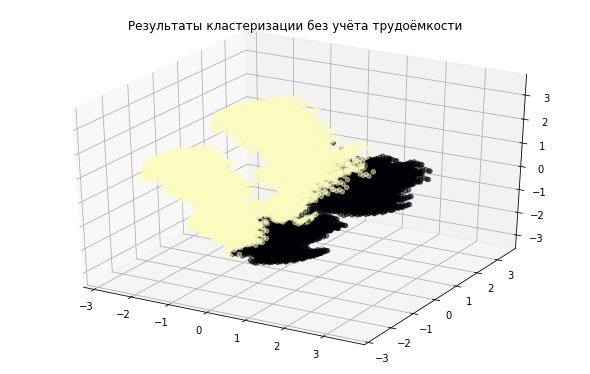

In [36]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans2, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

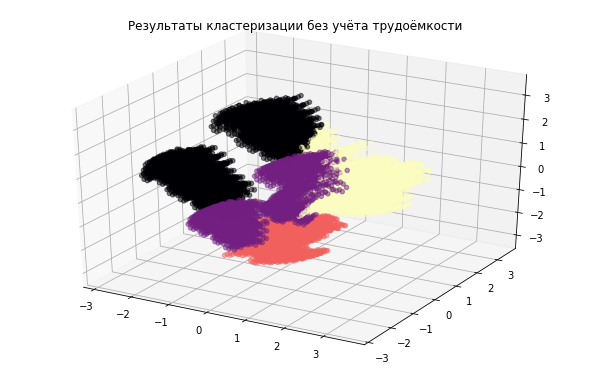

In [37]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans4, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

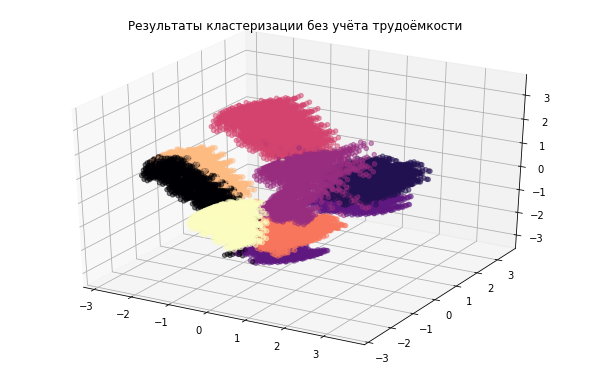

In [38]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans8, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

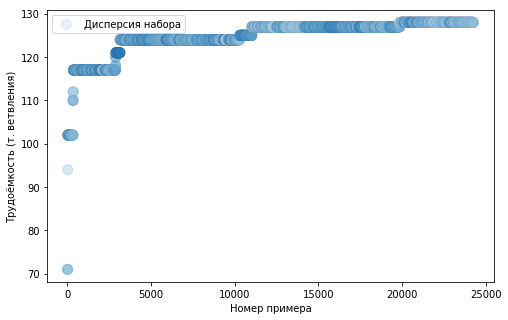

In [39]:
fig = plt.figure(figsize=(8,5))
colors = [np.var(json.loads(i.replace(" ", ', '))) for i in df.Instance.values]
plt.scatter(np.arange(len(df.Complexity)), df.Complexity.values, s=100, c=colors, cmap='Blues', alpha=0.1, label="Дисперсия набора")
plt.xlabel("Номер примера")
plt.ylabel("Трудоёмкость (т. ветвления)")
#plt.title("")
plt.legend()
#plt.grid()

# Аппроксимируем расписание (пока не готово)

In [42]:
orig_s = TaskSet(8)
orig_s

  r  |  p  |  d  
[[  4.  13.  31.]
 [ 23.  11.  52.]
 [ 34.  42. 158.]
 [ 55.  11. 110.]
 [ 72.  25. 135.]
 [ 73.  13. 150.]
 [ 82.  27. 111.]
 [ 99.  58. 168.]]

In [43]:
m = max(orig_s.array.flatten().tolist())

In [91]:
s = orig_s.array / m * 6

In [92]:
N_POINTS = 6
r_addition = N_POINTS - max(s[:,0])
d_addition = N_POINTS - max(s[:,2])
s[:,0] = s[:,0] + r_addition
s[:,2] = s[:,2] + d_addition

In [93]:
s[s < 1] = 1

In [94]:
s = TaskSet(np.round(s).astype(int))

In [95]:
s.array = np.array(sorted(s.array.tolist(), key=r))

In [96]:
s

  r  |  p  |  d  
[[3 1 1]
 [3 1 2]
 [4 2 6]
 [4 1 4]
 [5 1 5]
 [5 1 5]
 [5 1 4]
 [6 2 6]]

In [97]:
def taskset_to_coords(s):
    return s.array.flatten()

In [98]:
taskset_to_coords(s)

array([3, 1, 1, 3, 1, 2, 4, 2, 6, 4, 1, 4, 5, 1, 5, 5, 1, 5, 5, 1, 4, 6,
       2, 6])

In [15]:
data = df[['Instance', 'Schedule']].values

In [16]:
def to_coords(s):
    return json.loads(s.replace(' ', ', '))

In [17]:
X = np.array(list(map(to_coords, data[:,0])))

In [18]:
Y = df.index

In [65]:
knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')

In [66]:
knn.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [67]:
prediction = knn.predict([taskset_to_coords(s)])[0]

In [68]:
prediction

3243

In [103]:
np.array(to_coords(df.loc[prediction].Instance)).reshape((8,3))

array([[4, 2, 3],
       [4, 2, 4],
       [4, 2, 6],
       [5, 2, 4],
       [5, 2, 5],
       [5, 2, 6],
       [5, 3, 5],
       [6, 3, 6]])

In [100]:
s

  r  |  p  |  d  
[[3 1 1]
 [3 1 2]
 [4 2 6]
 [4 1 4]
 [5 1 5]
 [5 1 5]
 [5 1 4]
 [6 2 6]]

In [104]:
orig_s

  r  |  p  |  d  
[[  4.  13.  31.]
 [ 23.  11.  52.]
 [ 34.  42. 158.]
 [ 55.  11. 110.]
 [ 72.  25. 135.]
 [ 73.  13. 150.]
 [ 82.  27. 111.]
 [ 99.  58. 168.]]

In [108]:
predpi = df.loc[prediction].Schedule
predpi = json.loads(predpi)
predpi

[0, 1, 3, 4, 6, 2, 5, 7]

In [109]:
pi, c = main(orig_s)
pi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


[0, 1, 2, 3, 6, 4, 5, 7]

In [106]:
pi, c = main(s)
pi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


[0, 1, 3, 6, 4, 4, 2, 7]

In [110]:
orig_s[predpi].L_max()

69.0

In [111]:
orig_s[pi].L_max()

42.0

In [ ]:
data = df[['Instance', 'Schedule']].values
X = np.array(list(map(to_coords, data[:,0])))
Y = df.index

def taskset_to_coords(s):
    return s.array.flatten()

def to_coords(s):
    return json.loads(s.replace(' ', ', '))

def approx_pi(s):
    

In [242]:
df.loc[23759]

Complexity                                                   71
L_max                                                        20
Orig time                                               1.40835
Schedule                               [0, 1, 2, 4, 3, 5, 6, 7]
Instance      [4 3 4 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
Name: 23759, dtype: object

In [240]:
df.iloc[1]

Complexity                                                   71
L_max                                                        20
Orig time                                               1.40835
Schedule                               [0, 1, 2, 4, 3, 5, 6, 7]
Instance      [4 3 4 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
Name: 23759, dtype: object

In [241]:
df

,Complexity,L_max,Orig time,Schedule,Instance
24254,71,22,1.316322,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 5 6 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
23759,71,20,1.408346,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 3 4 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
11403,71,19,1.284701,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 2 3 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
17822,71,19,1.459950,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 2 4 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
24245,71,21,1.338994,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 4 5 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
21252,71,19,1.286950,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 2 5 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
24209,71,20,1.348474,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 3 6 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
22967,71,19,1.172124,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 2 6 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
24253,71,21,1.408448,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 4 6 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
24089,71,20,1.355661,"[0, 1, 2, 4, 3, 5, 6, 7]",[4 3 5 5 2 4 5 2 5 5 2 6 5 3 5 5 3 6 5 4 6 6 3 6]
